In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm, eigh
import os
%matplotlib widget



# Electric field functions
def E_omega(t, E0_au, omega_au, t0_au, tau_au, phi1):
    # Set the time limit to 3 standard deviations (tau_au)
    t_limit = 3 * tau_au
    time_abs = np.abs(t - t0_au)
    
    return np.where(time_abs < t_limit, 
                    E0_au * np.exp(-((t - t0_au) / tau_au) ** 2) * ((np.cos(omega_au * t + phi1))), 
                    0)

def E_2omega(t, E02_au, omega_au, t0_au, tau_au, phi2):
    t_limit = 3 * tau_au
    time_abs = np.abs(t - t0_au)
    return np.where(time_abs < t_limit, 
                    E02_au * np.exp(-((t - t0_au) / tau_au) ** 2) * ((np.cos(2*omega_au * t + phi2))),
                    0)




## For decay
# Energies and dipole elements
omega_s_eV, omega_p_eV, omega_es_eV, omega_ep_eV, omega_ed_eV = -24.6, -3.4, 17.8, 17.8, 17.8
omega_s, omega_p = omega_s_eV*0.0367493, omega_p_eV*0.0367493
omega_es, omega_ep, omega_ed = omega_es_eV*0.0367493, omega_ep_eV*0.0367493, omega_ed_eV*0.0367493

# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0, 0, 0, 0],
    [0, omega_p, 0, 0, 0],
    [0, 0, omega_es, 0, 0],
    [0, 0, 0, omega_ep, 0],
    [0, 0, 0, 0, omega_ed]
], dtype=complex)


# Define the decay term in atomic units
decay = 0.0367493j  #1 eV is approximately 0.0367493 atomic units. Therefore, 10 eV is approximately 10 × 0.0367493 = 0.367493 atomic units.
# Introduce the decay term to the excited states
H0[2, 2] -= decay  # omega_es
H0[3, 3] -= decay  # omega_ep
H0[4, 4] -= decay  # omega_ed

#print(H0)

# Hamiltonian function
def hamiltonian(t, d_ped, d_pes, d_sep, d_sp):
    E_om = E_omega(t, E0_au, omega_au, t0_au, tau_au, phi1)
    E_2om = E_2omega(t, E02_au, omega_au, t0_au, tau_au, phi2)
    return np.array([
        [0, d_sp * E_om, 0, d_sep * E_2om, 0],
        [d_sp * E_om, 0, d_pes * E_om, 0, d_ped * E_om],
        [0, d_pes * E_om, 0, 0, 0],
        [d_sep * E_2om, 0, 0, 0, 0],
        [0, d_ped * E_om, 0, 0, 0]
    ], dtype=complex)

In [3]:
def tdse_solver(omega_ev):
    global omega_au
    omega_au = omega_ev*0.0367493
    #H0_au = H0(omega_s, omega_p, omega_es, omega_ep, omega_ed)
    H0_au = H0
    U0_half_dt = expm(-1j * H0_au * dt / 2)

    #print(f"Omega: {omega_au}")
    dfs = {} # DataFrames for the all the populations at each time step
    dfp = {} # DataFrames for the all the populations at final time step
    # Initial state
    psi_0 = np.array([1, 0, 0, 0, 0], dtype=complex)
    psi_t_list = [psi_0]
    psi_pop = []
    
    for index in range(len(t_values)-1):
        t = t_values[index] 
        hamil_t = hamiltonian(t, d_ped, d_pes, d_sep, d_sp)
        eigenvalues, eigenvectors = eigh(hamil_t)
        assert np.allclose(hamil_t, hamil_t.T.conj()), "Hamiltonian is not Hermitian"
        assert np.allclose(np.dot(eigenvectors.T.conj(), eigenvectors), np.eye(len(hamil_t))), "Eigenvectors are not unitary"
        psi_dt = psi_t_list[index]
        psi_0_u0 = np.dot(U0_half_dt, psi_dt)
        psi_0_eigenbasis = np.dot(eigenvectors.T.conj(), psi_0_u0)
        u_t = np.diag(np.exp(-1j * eigenvalues * dt ))
        psi_t_eigenbasis = np.dot(u_t, psi_0_eigenbasis)
        psi_t_pre = np.dot(eigenvectors, psi_t_eigenbasis)
        psi_t_u0 = np.dot(U0_half_dt, psi_t_pre)
        psi_t_list.append(psi_t_u0)
        psi_pop.append(np.abs(psi_t_u0)**2)
        #print(np.abs(psi_t_U0))
    psi_t_array = np.array(psi_t_list)
    dfs[f'df_psi_{round(omega_ev,4)}'] = pd.DataFrame(psi_t_array, columns=['s', 'p', 'es', 'ep', 'ed'])

    psi_pop_array = np.array(psi_pop)
    dfp[f'df_pop_{round(omega_ev,4)}'] = pd.DataFrame(psi_pop_array, columns=['s', 'p', 'es', 'ep', 'ed'])
    return dfs, dfp

In [4]:
os.chdir('/asap3/flash/gpfs/fl26/2023/data/11015602/shared/Harijyoti/')
os.getcwd()

'/asap3/flash/gpfs/fl26/2023/data/11015602/shared/Harijyoti'

In [6]:
# Energies and dipole elements
omega_s_eV, omega_p_eV, omega_es_eV, omega_ep_eV, omega_ed_eV = -24.6, -3.383826, 17.832347999999996, 17.832347999999996, 17.832347999999996
d_sp  = 0.45
omega_s, omega_p = omega_s_eV*0.0367493, omega_p_eV*0.0367493
omega_es, omega_ep, omega_ed = omega_es_eV*0.0367493, omega_ep_eV*0.0367493, omega_ed_eV*0.0367493
# Time array(in fs)
start_time = -200  # fs
stop_time = 200 # fs
steps = 100000  # steps

t_values_SI = np.linspace(start_time, stop_time, steps)  # Time array in femtoseconds
t_values = t_values_SI * 41  # Time array in atomic units

# Time step
dt = t_values[1] - t_values[0]

# Electric Field parameters
phi1 = 0.0
phi2 = 0.0
tau = 40  # fs
tau_au = tau * 41
t0 = 0 # fs  # setting t0 to a non-zero value to avoid zero limit issue
t0_au = t0 * 41
E0_au = 0.0005
E02_au = 0.00005
#d_pes, d_sep, d_ped = 0.001, 0.0002, 0.0015
d_pes, d_sep, d_ped = 0.0015, 0.0002, 0.001





omega = 21.2 * 0.0367493
# Markers and annotations
t_limit = 3 * tau
E_field = E_omega(t_values, E0_au, omega, t0_au, tau_au, phi1)
E_2field = E_2omega(t_values, E02_au, omega_au, t0_au, tau_au, phi2)
plt.figure()
plt.plot(t_values_SI, E_field, label='Electric Field')
plt.plot(t_values_SI, E_2field, label='2w Electric Field')

plt.axvline(x=t_limit, color='r', linestyle='--', label=f'+{t_limit:.2f} fs Limit')
plt.axvline(x=-t_limit, color='b', linestyle='--', label=f'-{t_limit:.2f} fs Limit')

plt.xlabel('Time (femtoseconds)')
plt.ylabel('Electric Field (atomic units)')
plt.title('Electric Field vs Time')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'omega_au' is not defined

In [40]:
# Running simulations for a range of omega values
steps_eV = 0.001
omega_values = np.round(np.arange(21.1, 21.3, steps_eV), 3)
results_dfs = {}
results_dfp = {}

# Create output directory if it does not exist
output_dir = f'simulation_results_optimisized_{tau}fs_V2.2'
os.makedirs(output_dir, exist_ok=True)

for omega_ev in omega_values:
    print(f"Running simulation for omega = {round(omega_ev, 3)} eV")
    dfs1, dfp1 = tdse_solver(omega_ev)
    dfs1[f'df_psi_{omega_ev}'].to_csv(os.path.join(output_dir, f'psi_t_stepseV_{steps_eV}_{round(omega_ev, 3)}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.csv'), index=False)
    dfp1[f'df_pop_{omega_ev}'].to_csv(os.path.join(output_dir, f'pop_t_stepseV_{steps_eV}_{round(omega_ev, 3)}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.csv'), index=False)
    results_dfs.update(dfs1)
    results_dfp.update(dfp1)
    print(f"Completed simulation for omega = {round(omega_ev, 3)} eV")

# Save dictionary objects
results_dfs_path = os.path.join(output_dir, f"results_dfs_stepseV_{steps_eV}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.pkl")
results_dfp_path = os.path.join(output_dir, f"results_dfp_stepseV_{steps_eV}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.pkl")

pd.to_pickle(results_dfs, results_dfs_path)
pd.to_pickle(results_dfp, results_dfp_path)

print(f"All simulations completed and results saved to {output_dir}")

Running simulation for omega = 21.1 eV
Completed simulation for omega = 21.1 eV
Running simulation for omega = 21.101 eV
Completed simulation for omega = 21.101 eV
Running simulation for omega = 21.102 eV
Completed simulation for omega = 21.102 eV
Running simulation for omega = 21.103 eV
Completed simulation for omega = 21.103 eV
Running simulation for omega = 21.104 eV
Completed simulation for omega = 21.104 eV
Running simulation for omega = 21.105 eV
Completed simulation for omega = 21.105 eV
Running simulation for omega = 21.106 eV
Completed simulation for omega = 21.106 eV
Running simulation for omega = 21.107 eV
Completed simulation for omega = 21.107 eV
Running simulation for omega = 21.108 eV
Completed simulation for omega = 21.108 eV
Running simulation for omega = 21.109 eV
Completed simulation for omega = 21.109 eV
Running simulation for omega = 21.11 eV
Completed simulation for omega = 21.11 eV
Running simulation for omega = 21.111 eV
Completed simulation for omega = 21.111 e

KeyboardInterrupt: 

In [19]:
subarray = t_values[(t_values >= (3*tau_au-20)) & (t_values <= 3*tau_au)]  ## Where electric field is non-zero
indices = np.where((t_values >= (3*tau_au-20)) & (t_values <= 3*tau_au))[0]
#print(indices[- 1])

In [20]:
populations = []
populationp = []
populationes = []
populationep = []
populationed = []
iloc_val = indices[- 1]
for omega_ev in omega_values:
    #print(omega_ev)
    df = results_dfp[f'df_pop_{omega_ev}']
    populations.append(df['s'].iloc[iloc_val])
    populationp.append(df['p'].iloc[iloc_val])
    populationes.append(df['es'].iloc[iloc_val])
    populationep.append(df['ep'].iloc[iloc_val])
    populationed.append(df['ed'].iloc[iloc_val])    
    

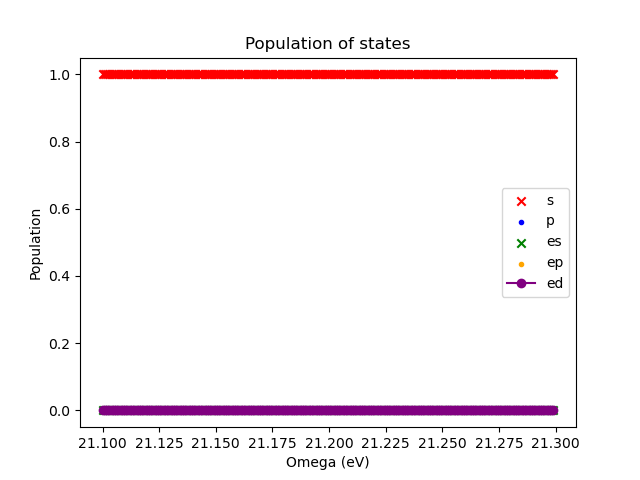

In [21]:
#populations = np.array(populations).astype(int)
plt.figure()
plt.scatter(omega_values, populations, marker='x', label='s' , color='red')
plt.scatter(omega_values, populationp, marker='.', label='p', color='blue')
plt.scatter(omega_values, populationes, marker='x', label='es', color='green')
plt.scatter(omega_values, populationep, marker='.', label='ep', color='orange')
plt.plot(omega_values, populationed, label='ed', marker='o', color='purple')
plt.title('Population of states')
plt.xlabel('Omega (eV)')
plt.ylabel('Population')
#plt.legend(['s', 'p', 'es', 'pes', 'ed'])
#plt.legend(['es', 'ep', 'ed'])
plt.legend()
#plt.xlim(21.09, 21.2)
#plt.ylim(0, 3e-17)
plt.show()

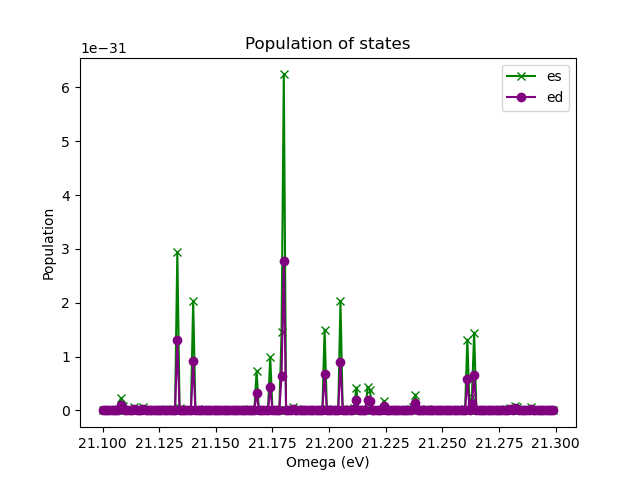

In [23]:
#populations = np.array(populations).astype(int)
plt.figure()
#plt.scatter(omega_values, populations, marker='x', label='s' , color='red')
#plt.scatter(omega_values, populationp, marker='.', label='p', color='blue')
plt.plot(omega_values, populationes, marker='x', label='es', color='green')
#plt.plot(omega_values, populationep, marker='.', label='ep', color='orange')
plt.plot(omega_values, populationed, label='ed', marker='o', color='purple')
#plt.axvline(x=Ecooper, color='brown', linestyle='--', label='Cooper Minimum')
#plt.axvline(x=Eres, color='black', linestyle='--', label='Resonance')
plt.title('Population of states')
plt.xlabel('Omega (eV)')
plt.ylabel('Population')
plt.legend()
#plt.xlim(21.09, 21.35)
#plt.ylim(0, 3e-17)
plt.show()
#plt.close()

## Compare with Chris Green values

In [109]:
data=np.loadtxt('c_phi_spd_40_45 (no phase jumps).dat',skiprows=1)
data[1294:2874,2]=-data[1294:2874,2]
data[1294:1564,6]=-data[1294:1564,6]

FileNotFoundError: c_phi_spd_40_45 (no phase jumps).dat not found.

In [ ]:
Ew= E0_au
E2w= E02_au

DeltaPhi=0

omega=data[:,1]/2
c0=data[:,2]*Ew**2
c1=data[:,4]*E2w
c2=data[:,6]*Ew**2
phi0=data[:,3]
phi1=data[:,5]
phi2=data[:,7]

Wtot=c0**2 + c1**2 + c2**2
beta1=(2*np.sqrt(3)*c0*c1*np.cos(DeltaPhi-(phi0-phi1))
      +(4/np.sqrt(3))*c1*c2*np.cos(DeltaPhi-(phi2-phi1)))/Wtot
beta2=(2*c1**2 + (10/7)*c2**2 + 2*np.sqrt(5)*c0*c2*np.cos(phi2-phi0))/Wtot
beta3=((6/np.sqrt(3))*c1*c2*np.cos(DeltaPhi-(phi2-phi1)))/Wtot
beta4=((18/7)*c2**2)/Wtot

Ecooper=(-c2[1563]/(c2[1564]-c2[1563]))*(omega[1564]-omega[1563])+omega[1563]
Eres=21.216174

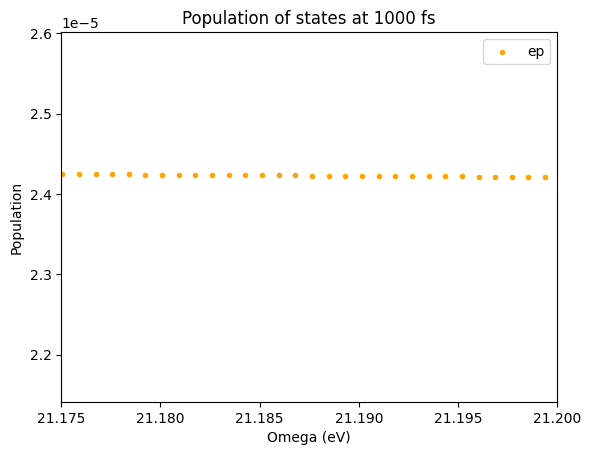

In [ ]:
%matplotlib inline
#plt.scatter(omega, c0, marker='x', label='es', color='green')
plt.scatter(omega, c1, marker='.', label='ep', color='orange')
#plt.scatter(omega, c2, label='ed', marker='o', color='purple')
plt.title('Population of states at 1000 fs')
plt.xlabel('Omega (eV)')
plt.ylabel('Population')
#plt.legend(['s', 'p', 'es', 'pes', 'ed'])
#plt.legend(['es', 'ep', 'ed'])
plt.legend()
plt.xlim(21.175, 21.2)
plt.show()

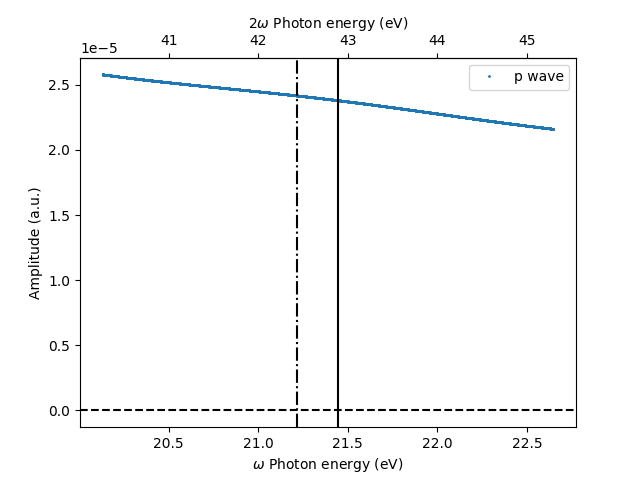

In [ ]:
fig,ax = plt.subplots()
#ax.plot(omega,c0,'.',label='s wave',markersize=2)
ax.plot(omega,c1,'.',label='p wave',markersize=2)
#ax.plot(omega,c2,'.',label='d wave',markersize=2)
ax.axvline(x=Ecooper,color='black')
ax.axvline(x=Eres,color='black',ls='dashdot')
ax.axhline(y=0,color='black',ls='--')
#plt.yscale('symlog')
ax.set_xlabel(r'$\omega$ Photon energy (eV)')
ax.set_ylabel('Amplitude (a.u.)')
#ax.set_xlim(21.2161,21.2162)
#ax.set_ylim(-0.02,0.02)
plt.legend()
ax2=ax.secondary_xaxis('top',functions=(lambda x:x*2, lambda x:x/2))
ax2.set_xlabel(r'2$\omega$ Photon energy (eV)')
plt.show()
#plt.close()